In [1]:
from sklearn.pipeline import Pipeline
import nbimporter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor, plot_importance
from sklearn.svm import SVR
from catboost import CatBoostRegressor

In [2]:
df = pd.read_csv("../Data_Folder/preprocessed_youtube_data.csv")

In [3]:
df = df.dropna(subset=["views"])

In [4]:
X = df.drop(columns=["views"])
y = df["views"]

In [5]:
# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Predicting/Modeling

In [6]:
def evaluate_model(y_true, y_pred, verbose=True):
    rmse = root_mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mask = np.array(y_true) != 0
    mape = np.mean(np.abs((np.array(y_true)[mask] - np.array(y_pred)[mask]) / np.array(y_true)[mask])) * 100

    if verbose:
        print(f"RMSE: {rmse:.4f}")
        print(f"MAE:  {mae:.4f}")
        print(f"R²:   {r2:.4f}")
        print(f"MAPE: {mape:.2f}%")

In [7]:
def train_and_evaluate_model(model_name, estimator, param_grid, X_train, y_train, X_test, y_test):
    if param_grid is not None:
        pipeline = Pipeline([("model", estimator)])
        search = GridSearchCV(pipeline, param_grid, scoring="neg_root_mean_squared_error", cv=3, n_jobs=-1)
        search.fit(X_train, y_train)
        best_model = search.best_estimator_
        preds = best_model.predict(X_test)
        print(f"\n {model_name} Results (with Grid Search)")
        print("Best Parameters:", search.best_params_)
    else:
        estimator.fit(X_train, y_train)
        preds = estimator.predict(X_test)
        best_model = estimator
        print(f"\n {model_name} Results (no tuning)")

    evaluate_model(y_test, preds)
    return best_model, preds


In [8]:
xgb_params = {
    "model__n_estimators": [100, 200, 500],
    "model__max_depth": [3, 6, 8, 10],
    "model__learning_rate": [0.05, 0.1, 0.2]
}

cat_params = {
    "model__iterations": [200, 500, 800],
    "model__depth": [4, 6, 6, 8],
    "model__learning_rate": [0.05, 0.1]
}


xgb_model, xgb_preds = train_and_evaluate_model(
    "XGBoost",
    XGBRegressor(random_state=42),
    xgb_params,
    X_train, y_train, X_test, y_test
)

cat_model, cat_preds = train_and_evaluate_model(
    "CatBoost",
    CatBoostRegressor(verbose=0, random_state=42),
    cat_params,
    X_train, y_train, X_test, y_test
)

svm_model, svm_preds = train_and_evaluate_model(
    "SVR",
    SVR(kernel="rbf"),
    param_grid=None,
    X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test
)

lr_model, lr_preds = train_and_evaluate_model(
    "Linear Regression",
    LinearRegression(),
    param_grid=None,
    X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test
)



 XGBoost Results (with Grid Search)
Best Parameters: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 100}
RMSE: 1416874.8043
MAE:  754843.4952
R²:   -0.0630
MAPE: 275097.04%

 CatBoost Results (with Grid Search)
Best Parameters: {'model__depth': 4, 'model__iterations': 200, 'model__learning_rate': 0.05}
RMSE: 1381887.5631
MAE:  746029.0536
R²:   -0.0111
MAPE: 293170.32%

 SVR Results (no tuning)
RMSE: 1449451.6356
MAE:  526671.8496
R²:   -0.1124
MAPE: 40297.03%

 Linear Regression Results (no tuning)
RMSE: 1463847.3533
MAE:  793833.7542
R²:   -0.1346
MAPE: 363938.93%


In [9]:
def plot_actual_vs_predicted(y_true, y_pred, model_name="Model"):
    plt.figure(figsize=(6, 4))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.xlabel("Actual Views")
    plt.ylabel("Predicted Views")
    plt.title(f"{model_name}: Actual vs Predicted")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

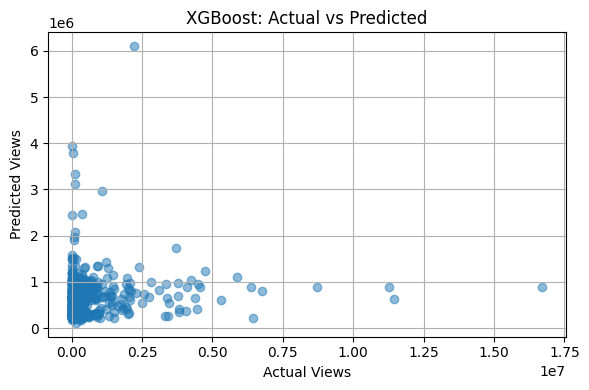

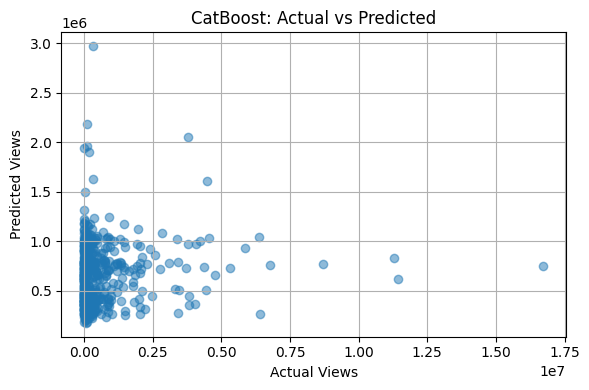

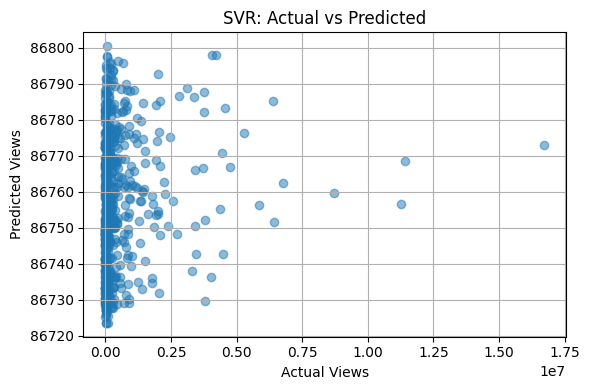

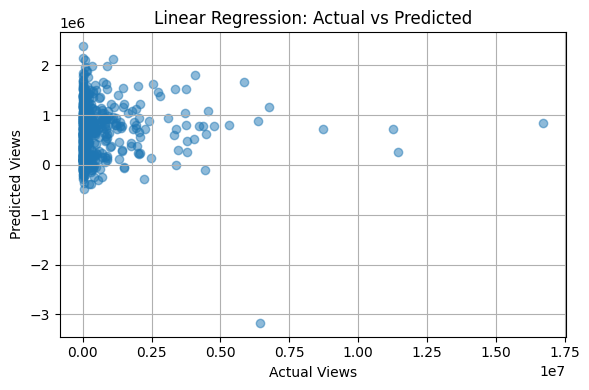

In [10]:
plot_actual_vs_predicted(y_test, xgb_preds, "XGBoost")
plot_actual_vs_predicted(y_test, cat_preds, "CatBoost")
plot_actual_vs_predicted(y_test, svm_preds, "SVR")
plot_actual_vs_predicted(y_test, lr_preds, "Linear Regression")


In [11]:
def plot_residuals(y_true, y_pred, model_name="Model"):
    residuals = y_true - y_pred

    plt.figure(figsize=(6, 4))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicted Views")
    plt.ylabel("Residuals")
    plt.title(f"{model_name}: Residual Plot")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


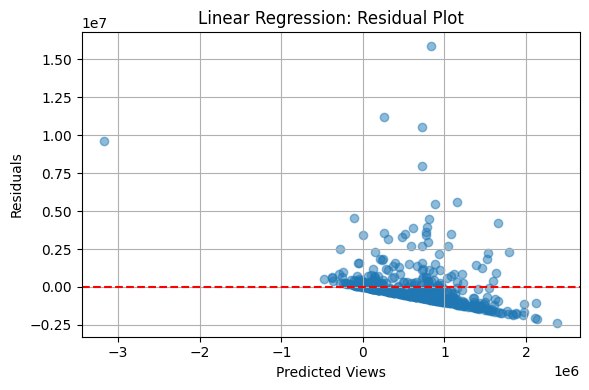

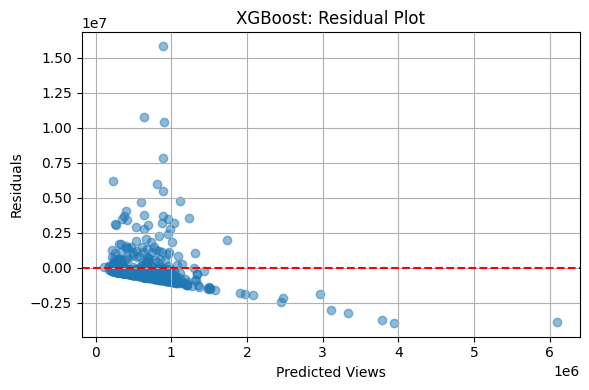

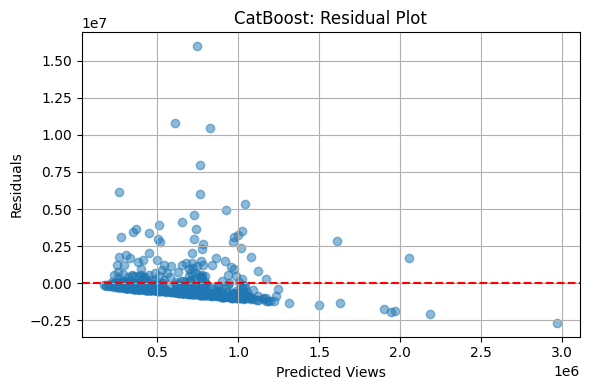

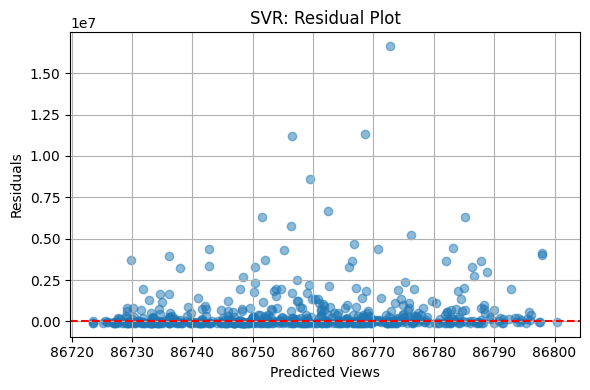

In [12]:
plot_residuals(y_test, lr_preds, "Linear Regression")
plot_residuals(y_test, xgb_preds, "XGBoost")
plot_residuals(y_test, cat_preds, "CatBoost")
plot_residuals(y_test, svm_preds, "SVR")


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

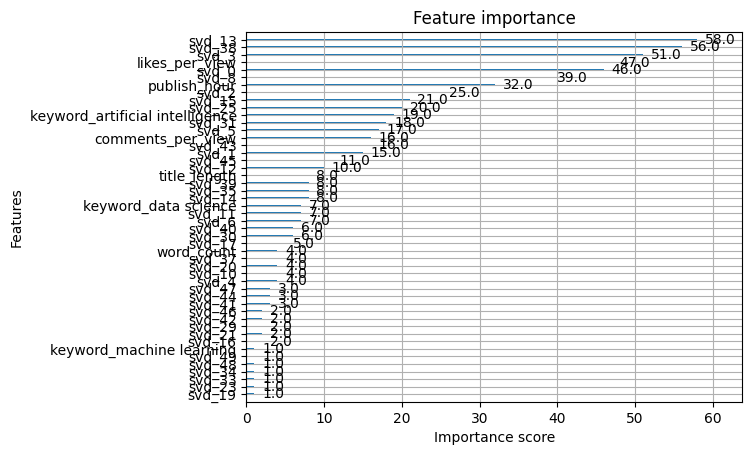

In [13]:
plot_importance(xgb_model.named_steps['model'])